**Import CIFAR-10 dataset**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    
    '''
    A class to create an unbalanced CIFAR-10 dataset.

    The implementation for this class has been provided by my dissertation supervisor Konstantinos Alexandridis,
    the source of this code can be found in the GitHub repository here:
    https://github.com/kostas1515/iif/blob/master/classification/imbalanced_dataset.py

    '''

    cls_num = 10

    def __init__(self, root, imb_type='exp', imb_factor=0.01, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

In [2]:
def create_sampled_CIFAR10_data():

    '''
    A function that uses the IMBALANCECIFAR10 class to load the CIFAR-10 data,
    with data sampled from each class to create an unbalanced training dataset.
    The test dataset remain balanced so that the metrics produced make use of all test data available.

    Inputs:
        None

    Returns:
        trainset: Unbalanced CIFAR-10 dataset, sampled at an exponentially decreasing rate from each class
        trainloader: PyTorch dataloader for the sampled training data
        testset: CIFAR-10 test data, the test data is sampled equally from each class
        testloader: PyTorch dataloader for the sampled test data
    '''

    transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    trainset = IMBALANCECIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = IMBALANCECIFAR10(root='./data', train=False, download=True, transform=transform_val, imb_factor=1)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)    
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    return trainset, trainloader, testset, testloader

In [3]:
trainset, trainloader, testset, testloader = create_sampled_CIFAR10_data()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Plot numbers of images in each class**

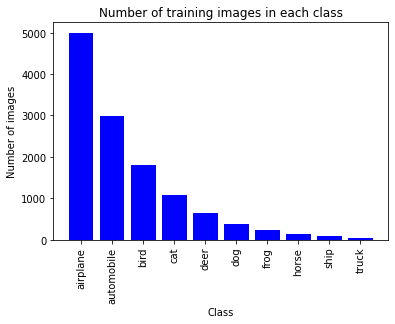

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x_labels = trainset.classes
x = [i for i,_ in enumerate(x_labels)]
y = []

labels = np.array(trainset.targets)
for cls in range(len(x_labels)):
  y.append(len(np.where(labels == cls)[0]))

plt.bar(x,y,color='blue')
plt.xticks(x, x_labels, rotation=90)
plt.ylabel('Number of images')
plt.xlabel('Class')
plt.title('Number of training images in each class')
plt.show()

**Creating ResNet model**

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional

In [6]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    '''
    A function to create a 3x3 convolutional layer with padding

    The implementation is taken from the official PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    (site last accessed 13:48 on 6th September 2021)
    '''
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    '''
    A function to create a 1x1 convolutional layer

    The implementation is taken from the official PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    (site last accessed 13:48 on 6th September 2021)
    ''' 
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [7]:
class BasicBlock(nn.Module):
    '''
    A class to construct the BasicBlock of the ResNet model

    The implementation is taken from the official PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    (site last accessed 13:48 on 6th September 2021)
    '''
    
    expansion: int = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1, downsample: Optional[nn.Module] = None, groups: int = 1, base_width: int = 64, dilation: int = 1, norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(BasicBlock, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [8]:
class Bottleneck(nn.Module):
    '''
    A class to construct the Bottleneck of the ResNet model

    The implementation is taken from the PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    (site last accessed 13:48 on 6th September 2021)
    '''

    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(self, inplanes: int, planes: int, stride: int = 1, downsample: Optional[nn.Module] = None, groups: int = 1, base_width: int = 64, dilation: int = 1, norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(Bottleneck, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        width = int(planes * (base_width / 64.)) * groups
        
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [9]:
class ResNet(nn.Module):
    '''
    A class to construct the ResNet model

    The implementation is taken from the official PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    (site last accessed at 13:48 on 6th September 2021)
    '''


    def __init__(self, block: Type[Union[BasicBlock, Bottleneck]], layers: List[int], num_classes: int = 1000, zero_init_residual: bool = False, groups: int = 1, width_per_group: int = 64, replace_stride_with_dilation: Optional[List[bool]] = None, norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(ResNet, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        self.groups = groups
        self.base_width = width_per_group
        
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        
        if dilate:
            self.dilation *= stride
            stride = 1
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        
        self.inplanes = planes * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)


    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


In [10]:
def ResNet18():
    '''
    A function that creates a ResNet18 model with two nodes in the output layer
    '''
    return ResNet(BasicBlock, [2,2,2,2], 10)

**Training function**


*   One forward pass through the network, the loss function is not reduced
*   Obtain the losses for each class of images, and back-propagate each closs through the network. Store the "knowledge" due to each image class



In [11]:
import copy

def train_congestion_avoider_10_classes(device, model, trainloader, criterion, optimizer, cls_num, epoch_counts, grads):

  '''
  A function to train a ResNet model on the CIFAR-10 dataset with ten classes.
  The function calculates the values of the confusion matrix and subsequent metrics, as well as updating model weights.

  Inputs:
    device: string - The device the code is being run on
    model: The PyTorch ResNet model being trained
    trainloader: The PyTroch data loader for training data
    criterion: The loss criterion for the model
    optimizer: The model optimizer
    cls_num: int - The number of classes of images being trained
    epoch_counts: list - The number of epochs trained since the last congestion event
    grads: dict - The accumulated acquired knowledge for each image class & for each model parameter

  Returns:
    confusion_matrix: numpy matrix - confusion matrix for the model on the training data
    accuracy: float - accuracy of the model on the training data
    recalls: list - the recall for each class of images on the training data
    precisions: list - the precision for each class of images on the training data
    fScores: list - the F-score for each class of images on the training data
    grads: dict - the acquired knowledge for each model parameter for each class of input images
    epoch_counts: number of epochs trained since the last congestion event for each class of images
  '''

  model.train()
  start_time = time.time()

  # Initialise a numpy matrix of zeros that will be populated to create the confusion matrix
  confusion_matrix = np.zeros((cls_num, cls_num))

  # Perform a forward pass through the model for each batch of training images
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,targets)

    # For each class of images find the loss due to only that class
    masks = [targets == k for k in range(cls_num)]
    sub_losses = [loss[mask].mean() for mask in masks]
    
    for name,param in model.named_parameters():
        param.grad = None

    # For each class of images back-propagate the loss due to those images
    # Accumulate the acquired knowledge for each class and each model parameter
    for cls, sub_loss in enumerate(sub_losses):
      sub_loss.backward(retain_graph=True)
      for name,param in model.named_parameters():
        if name in grads[cls].keys():
          grads[cls][name] += torch.mul(copy.deepcopy(param.grad), optimizer.param_groups[0]['lr'])
        else:
          grads[cls][name] = torch.mul(copy.deepcopy(param.grad), optimizer.param_groups[0]['lr'])
        # After each backward pass the parameter gradient must be reset
        # This allows the next backward pass to only record the gradient due to that class of images
        param.grad=None
    
    # Update the model weights based on the total loss
    optimizer.zero_grad()
    loss.mean().backward()  
    optimizer.step()

    _, predicted = outputs.max(1)

    # Populate the confusion matrix with the results
    for target, pred in zip(targets, predicted):
        confusion_matrix[target][pred] += 1

  recalls = np.zeros((cls_num))
  precisions = np.zeros((cls_num))
  fScores = np.zeros((cls_num))

  epoch_counts = [x+1 for x in epoch_counts]

  # Calculate the recall, precision & F-score from the confusion matrix
  for cls in range(cls_num):
      if confusion_matrix.sum(1)[cls] != 0:
          recalls[cls] = confusion_matrix[cls][cls] / confusion_matrix.sum(1)[cls]
      else:
          recalls[cls] = 0
      if confusion_matrix.sum(0)[cls] != 0:
          precisions[cls] = confusion_matrix[cls][cls] / confusion_matrix.sum(0)[cls]
      else:
          precisions[cls] = 0
      if (precisions[cls] + recalls[cls]) != 0:
          fScores[cls] = 2 * precisions[cls] * recalls[cls] / (precisions[cls] + recalls[cls])
      else:
          fScores[cls] = 0

  accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

  return confusion_matrix, accuracy, recalls, precisions, fScores, grads, epoch_counts

In [12]:
def linear_cong_condition(min_cond, max_cond, epoch, max_epochs):

    '''
    A function that will linearly interpolate between two values.

    Inputs:
        min_cond: float - The lower bound that is to be interpolated
        max_cond: float - The upper bound that is to be interpolated
        epoch: int - the current epoch of training
        max_epochs: int - The total number of epochs during training

    Returns:
        condition: float - The value linearly interpolated between min_cond & max_cond
    '''

    condition = min_cond + (max_cond - min_cond) * (epoch / max_epochs)

    return condition

**Create congestion avoidance scheduler**

**Only return knowledge from weights with low cosine similarity (compared to all other classes)**

In [13]:
import torch.nn.functional as F

def congestion_avoid_10classes(cls_num, model, optimizer, metrics, condition, grads, min_epochs, mult, epoch_counts, boolean_values, num_class_avg, similarity_threshold):

    '''
    A function to determine if a congestion event has occurred.
    When a congestion event occurs the parameters of the model must 
    return a proportion of acquired knowledge. The dictionaries containing
    the acquired knowledge are updated to reflect the 'lost' knowledge.

    Inputs:
        cls_num: int - The number of classes of images being classified
        model: The PyTorch ResNet18 model being trained
        metrics: list - The values of metrics for each class in the mult-class classifier using the test data
        condition: float - The congestion condition parameter value
        grads: dict - Accumulated acquired knowledge for each model parameter due to images in each class
        min_epochs: int - The minimum number of epochs that must pass between successive congestion events on a model branch
        mult: float - The proportion of acquired knowledge to be returned on congestion
        epoch_counts: list - The number of epochs since the last congestion event for each class of images
        boolean_values: list of boolean values - True at index 'cls' if a congestion event occurs for class 'cls'
        num_class_avg: int - The number of metrics used to determine a congestion threshold value
        similarity_threshold: float - Only parameters with a lower minimum cosine similarity will return acquired knowledge on congestion

    Returns:
        optimizer: 
        model: The ResNet18 model being trained after parameter values have returned knowledge as required
        boolean_values: boolean - Has a congestion event occurred for each class of images
        epoch_counts: list - The number of epochs since the last congestion event for each class of images
        grads: dict - The accumulated acquired knowledge due to each class of images after any knowledge has been returned due to congestion
    '''

    # Create a threshold which is the average metric from a number of the worst performing classes
    threshold = np.average(np.sort(metrics)[:num_class_avg])

    for cls in range(cls_num):
        metric = metrics[cls]
        # If the metric of this class is sufficiently above the average of the worst classes
        # then the knowledge from that class is returned
        if (threshold < condition * metric) and (epoch_counts[cls] >= min_epochs):
            boolean_values[cls] = True
            print('Condition has been met (class {}) ..... {:.2f}% --> {:.2f}%'.format(cls,100.*threshold, 100.*metric))
            for name, value in model.named_parameters():
                # Create a list of cosine similarities for the gradient of this parameter
                # due to this class of images against the gradient due to all other image classes
                cosine_sims = [float(abs(F.cosine_similarity(grads[cls][name], grads[index][name], dim=-1)).mean()) for index in range(cls_num)]
                with torch.no_grad():
                    if name in grads[cls].keys():
                        # Only return knowledge if the minimum average cosine similarity is below the threshold
                        if min(cosine_sims) < similarity_threshold:
                              value += mult * grads[cls][name]
                              grads[cls][name] -= mult * grads[cls][name]
                              print('Gradient used: ', name, ', Cosine sim: ', min(cosine_sims))
                        else:
                            print('Cosine similarity too high: ', name, '--> ', min(cosine_sims))
                            pass
            epoch_counts[cls] = 0
    
        else:
            print('Condition not met (class {}) ..... {:.2f}% --> {:.2f}%'.format(cls,100.*threshold, 100.*metric))

    return optimizer, model, boolean_values, epoch_counts, grads

In [14]:
def test_congestion_avoider_10classes(cls_num, start_time, testloader, device, model, optimizer, scheduler, grads, criterion, epoch, max_epochs, min_cond, max_cond, min_epochs, mult, epoch_counts, num_class_avg, similarity_threshold, metric):

    ''' 
        A function to calculate the performance of the trained model on the test data.
        The congestion avoidance scheduler uses a congestion metric value to
        update network weights and dictionary of acquired knowledge as required.

    Inputs:
        cls_num: int - The number of classes of images being classified
        start_time: time the training procedure began
        testloader: The PyTroch data loader for the test data
        device: The device the code is being run on
        model: The PyTorch ResNet model being trained
        optimizer: The PyTorch optimizer being used for model weight updates (e.g. SGD)
        scheduler: The PyTorch learning rate scheduler being used
        grads: dict - The dictionary of acquired knowledge for each parameter due to each class of images
        criterion: The PyTorch loss criterion being used
        epoch: int - the epoch of the training process
        max_epochs: int - the total number of epochs the model will be trained for
        min_cond: float - the lower bound of the congestion condition parameter that will be interpolated between
        max_cond: float - the upper bound of the congestion condition parameter that will be interpolated between
        min_epochs: int - the minimum number of epochs that must pass between successive congestion events
        mult: float - the multiplicative decrease factor that determines the proportion of knowledge returned
        epoch_counts: list - the number of epochs since the last congestion event for each class of images
        num_class_avg: int - the number of images classes used to determine the congestion threshold metric value
        similarity_threshold: float - the cosine similarity threshold to determine which layers return knowledge
        metric: ['recall','precision','F-score'] - parameter to determine which metric is used to determine a congestion event

    Returns:
        optimizer: The PyTorch optimizer being used for model weight updates (e.g. SGD)
        accuracy: float - the total accuracy of the model
        precisions: list - the precision for each class of images
        recalls: list - the recall for each class of images
        fScores: list - the F-score for each class of images
        boolean_values: list - indicator of if a congestion event has occurred for each class of images
        grads: dict -  The dictionary of acquired knowledge for each parameter due to each class of images, after knowledge has been returned
        epoch_counts: list - the number of epochs since the last congestion event for each class of images
    '''

    import copy
    model.eval()

    # Create the numpy matrices that will store the metrics
    confusion_matrix = np.zeros((cls_num, cls_num))
    recalls = np.zeros((cls_num))
    precisions = np.zeros((cls_num))
    fScores = np.zeros((cls_num))
    boolean_values = np.zeros((cls_num))
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            _, predicted = outputs.max(1)

            # Populate the confusion matrix
            for target, pred in zip(targets, predicted):
                confusion_matrix[target][pred] += 1
    
        # Calculate the precision, recall & F-score from the confusion matrix
        for cls in range(cls_num):
            if confusion_matrix.sum(1)[cls] != 0:
                recalls[cls] = confusion_matrix[cls][cls] / confusion_matrix.sum(1)[cls]
            else:
                recalls[cls] = 0
            if confusion_matrix.sum(0)[cls] != 0:
                precisions[cls] = confusion_matrix[cls][cls] / confusion_matrix.sum(0)[cls]
            else:
                precisions[cls] = 0
            if (precisions[cls] + recalls[cls]) != 0:
                fScores[cls] = 2 * precisions[cls] * recalls[cls] / (precisions[cls] + recalls[cls])
            else:
                fScores[cls] = 0

        accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

        condition = linear_cong_condition(min_cond, max_cond, epoch, max_epochs)
        
        if metric == 'precision':
            congestion_metric = precisions
        elif metric == 'recall':
            congestion_metric = recalls
        elif metric == 'F-score':
            congestion_metric = fScores
        else:
            print('ERROR: Metric must be one of (precision, recall, F-score)')

        # Use the congestion avoidance scheduler to return acquired knowledge as is required
        optimizer, model, boolean_values, epoch_counts, grads = congestion_avoid_10classes(cls_num, model, optimizer, congestion_metric, condition, grads, min_epochs, mult, epoch_counts, boolean_values, num_class_avg, similarity_threshold)
        scheduler.step()

    print('time: %.3f sec'% ((time.time()-start_time)))
    print('Rows: Actual, Columns: Predicted')
    print(confusion_matrix)
    for cls in range(cls_num):
        print('Class %d A: : %.3f%% (%d/%d)'%(cls, 100*accuracy, np.trace(confusion_matrix), confusion_matrix.sum()))
        print('Class %d P: : %.3f%% (%d/%d)'%(cls, 100*precisions[cls], confusion_matrix[cls][cls], confusion_matrix.sum(0)[cls]))
        print('Class %d R: : %.3f%% (%d/%d)'%(cls, 100*recalls[cls], confusion_matrix[cls][cls], confusion_matrix.sum(1)[cls]))
        print('Class %d F: : %.3f%%'%(cls, 100*fScores[cls]))
        print('********************')


    return optimizer, accuracy, precisions, recalls, fScores, boolean_values, grads, epoch_counts

**Create function to train model with congestion avoidance scheduler**

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
import time
import torch.backends.cudnn as cudnn

def get_cong_avoidance_results_10classes(epochs=100, min_cond=0.5, max_cond = 0.5, mult=0.1, lr=0.1, min_epochs = 10, num_class_avg = 10, similarity_threshold = 0.2, metric='F-score'):

    '''
    A function to train the ResNet model for 100 epochs and use the congestion avoidance scheduler to return acquired knowledge.

    Inputs:
      epochs: int - The number of epochs the model will be trained for
      min_cond: float - the lower bound of the congestion condition parameter that will be interpolated between
      max_cond: float - the upper bound of the congestion condition parameter that will be interpolated between
      mult: float - the multiplicative decrease factor that determines the proportion of knowledge returned
      lr: float - the initial learning rate
      min_epochs: int - the minimum number of epochs that must pass between successive congestion events
      num_class_avg: int - the number of image classes used to determine the congestion threshold metric value
      similarity_threshold: float - the cosine similarity threshold to determine which layers return knowledge
      metric: ['recall','precision','F-score'] - parameter to determine which metric is used to determine a congestion event

    Returns:
      train_acc: numpy array - the training accuracy at each epoch of training
      train_P: numpy array - the training precision at each epoch of training for each class of images
      train_R: numpy array - the training recall at each epoch of training for each class of images
      train_F: numpy array - the training F-score at each epoch of training for each class of images
      test_acc: numpy array - the accuracy on the test data at each epoch of training
      test_P: numpy array - the precision on the test data at each epoch of training for each class of images
      test_R: numpy array - the recall on the test data at each epoch of training for each class of images
      test_F: numpy array - the F-score on the test data at each epoch of training for each class of images
      cong_events: numpy array - indicators showing which image classes in each epoch have congestion events
    '''

    # Create ResNet model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ResNet18()
    model = model.to(device)
    if device == 'cuda':
        print('CUDA device used...')
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    # Import data
    trainset, trainloader, testset, testloader = create_sampled_CIFAR10_data()

    # Create variables
    cls_num = len(trainset.classes)
    grads = {}
    for cls in range(cls_num):
        grads[cls] = {}
    epoch_counts = [0]*cls_num
    
    criterion= nn.CrossEntropyLoss(reduction='none')
    # CREATE MODEL OPTIMIZER
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=5e-4)
    scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=lr, step_size_up=10, mode="triangular2")

    # BEGIN RECORDING THE TIME
    start_time = time.time()

    # Create matrices to store results
    train_acc = np.zeros((epochs, 1))
    train_P = np.zeros((epochs, cls_num))
    train_R = np.zeros((epochs, cls_num))
    train_F = np.zeros((epochs, cls_num))
    test_acc = np.zeros((epochs, 1))
    test_P = np.zeros((epochs, cls_num))
    test_R = np.zeros((epochs, cls_num))
    test_F = np.zeros((epochs, cls_num))
    cong_events = np.zeros((epochs, cls_num))

    for epoch in range(epochs):
        print('\n********** EPOCH {} **********'.format(epoch + 1))
        print('Learning rate: ', optimizer.param_groups[0]['lr'])
        print('Epoch counts: ', epoch_counts)
        # Train the model for one epoch, accumulate the acquired knowledge & update model weights
        confusion_matrix, accuracy, recalls, precisions, fScores, grads, epoch_counts = train_congestion_avoider_10_classes(device, model, trainloader, criterion, optimizer, cls_num, epoch_counts, grads)
        # Record the metrics on the training data for that epoch
        train_acc[epoch] = accuracy
        train_P[epoch] = precisions
        train_R[epoch] = recalls
        train_F[epoch] = fScores
        # Test the model using the test data, then pass the metrics to the congestionavoidance scheduler
        # Knowledge is returned as required
        optimizer, accuracy, precisions, recalls, fScores, boolean_values, grads, epoch_counts = test_congestion_avoider_10classes(cls_num, start_time, testloader, device, model, optimizer, scheduler, grads, criterion, epoch, epochs, min_cond, max_cond, min_epochs, mult, epoch_counts, num_class_avg, similarity_threshold, metric)
        # Record the metrics on the test data for that epoch
        test_acc[epoch] = accuracy
        test_P[epoch] = precisions
        test_R[epoch] = recalls
        test_F[epoch] = fScores
        cong_events[epoch] = boolean_values

    return train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events

**Function that will save the results of training to a pickle file**

In [16]:
import pickle

def save_to_file(fileName, results):

    '''
    A function to save results from model training to a named file in the pickle format
    '''

    with open(fileName, 'wb') as file:
        for result in results:
            pickle.dump(result, file)

**Function that allow us to plot the results of training**

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pickle
import numpy as np


def moving_average(data, smooth_param):

    '''
    A function to calculate the moving average of a list of data

    Inputs:
      data: the raw data that will be smoothed
      smooth_param: int - the number of data items used to create each moving average value

    Returns:
      moving_averages: list - the smoothed data
    '''
    
    index = 0
    moving_averages = []
    
    while index < len(data) - smooth_param + 1:
        # Create a list of the data that will be used to calculate the average
        sub_data = data[index : index + smooth_param]
        average = sum(sub_data) / smooth_param
        moving_averages.append(average)
        index += 1

    return moving_averages


def plot_results_multiClass(name, colors, smooth = 5, vlines=True):

    '''
    A function to plot the performance metrics of the trained model for each class of images on the test data

    Inputs:
      name: string - the name of the file that contains the data to create the plots
      colors: list - A list of colors used for each line on the plots
      smooth: int - the level of smoothing used in the moving average function to smooth the data
      vlines: boolean - indicator to determine whether vertical lines are shown on the plot to show which epochs congestion events occur in

    Returns:
      None
    '''

    # Create a 2x2 subplot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
    idx_to_class = {0: 'airplane', 1: 'automobile', 
                    2: 'bird', 3: 'cat', 
                    4: 'deer', 5: 'dog', 
                    6: 'frog', 7: 'horse', 
                    8: 'ship', 9: 'truck'}


    # Read the pickle file to create the required variables
    with open(name, 'rb') as data:
        train_acc = pickle.load(data)
        train_P = pickle.load(data)
        train_R = pickle.load(data)
        train_F = pickle.load(data)
        test_acc = pickle.load(data)
        test_P = pickle.load(data)
        test_R = pickle.load(data)
        test_F = pickle.load(data)
        cong_events = pickle.load(data)

    cls_num = int(train_P[0].shape[0])
    
    # Plot the accuracy of the model
    ax[0,0].plot(moving_average(test_acc,smooth), color='k')
    ax[0,0].set_title('Accuracy \n(moving average of over {} epochs)'.format(smooth))
    ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # For each class of images plot the smoothed precision, recall & F-score in the corresponding subplot
    for cls in range(cls_num):
        ax[0,1].plot(moving_average(test_P[:,cls],smooth), color = colors[cls], label='Class {}: {}'.format(cls,idx_to_class[cls]))
        ax[1,0].plot(moving_average(test_R[:,cls],smooth), color = colors[cls], label='Class {}: {}'.format(cls,idx_to_class[cls]))
        ax[1,1].plot(moving_average(test_F[:,cls],smooth), color = colors[cls], label='Class {}: {}'.format(cls,idx_to_class[cls]))
    
    # If a congestion event has happened in that epoch then a vertical line is added to the graph at that epoch
    cong_events = np.sum(cong_events,1)
    if vlines:
        for i, event in enumerate(cong_events):
            if event > 0:
                ax[0,0].axvline(x=i, color='grey', linestyle='--', linewidth=0.5)
                ax[0,1].axvline(x=i, color='grey', linestyle='--', linewidth=0.5)
                ax[1,0].axvline(x=i, color='grey', linestyle='--', linewidth=0.5)
                ax[1,1].axvline(x=i, color='grey', linestyle='--', linewidth=0.5)
        
    # Add titles, axis formatting and legends to the plots
    ax[0,1].set_title('Precision \n(moving average of over {} epochs)'.format(smooth))
    ax[1,0].set_title('Recall \n(moving average of over {} epochs)'.format(smooth))
    ax[1,1].set_title('F-score \n(moving average of over {} epochs)'.format(smooth))
    ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    fig.text(0.5, 0.04, 'Epoch', ha='center', va='center')
    handles, labels = ax[1,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    fig.tight_layout()
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
    plt.show()


def plot_results_diff_multiClass(baseline, name, colors, smooth = 5, vlines=True):

    '''
    A function to plot the difference in performance metrics for the trained model using
    the congestion avoidance scheduler with the model without the congestion avoidance scheduler.

    Inputs:
      baseline: string - the name of the file that contains the data for the baseline position (i.e. no congestion avoidance)
      name: string - the name of the file that contains the data to create the plots
      colors: list - A list of colors used for each line on the plots
      smooth: int - the level of smoothing used in the moving average function to smooth the data
      vlines: boolean - indicator to determine whether vertical lines are shown on the plot to show which epochs congestion events occur in

    Returns:
      None
    '''

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
    idx_to_class = {0: 'airplane', 1: 'automobile', 
                    2: 'bird', 3: 'cat', 
                    4: 'deer', 5: 'dog', 
                    6: 'frog', 7: 'horse', 
                    8: 'ship', 9: 'truck'}

    # Read the pickle file containing the results when no congestion avoidance scheduler is used
    with open(baseline, 'rb') as baseline:
        base_train_acc = pickle.load(baseline)
        base_train_P = pickle.load(baseline)
        base_train_R = pickle.load(baseline)
        base_train_F = pickle.load(baseline)
        base_test_acc = pickle.load(baseline)
        base_test_P = pickle.load(baseline)
        base_test_R = pickle.load(baseline)
        base_test_F = pickle.load(baseline)
    
    # Read the pickle file containing the results when the congestion avoidance scheduler is used
    with open(name, 'rb') as data:
        train_acc = pickle.load(data)
        train_P = pickle.load(data)
        train_R = pickle.load(data)
        train_F = pickle.load(data)
        test_acc = pickle.load(data)
        test_P = pickle.load(data)
        test_R = pickle.load(data)
        test_F = pickle.load(data)
        cong_events = pickle.load(data)

    cls_num = int(train_P[0].shape[0])

    # Calculate the change to the accuracy in each epoch with the inclusion of congestion avoidance
    test_acc_diff = test_acc - base_test_acc
    
    ax[0,0].plot(moving_average(test_acc_diff,smooth), color='k')
    ax[0,0].set_title('Change to accuracy from baseline \n(moving average of over {} epochs)'.format(smooth))
    ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # For each class plot the change in recall, precision and F-score
    for cls in range(cls_num):
        test_P_diff = test_P[:,cls] - base_test_P[:,cls]
        test_R_diff = test_R[:,cls] - base_test_R[:,cls]
        test_F_diff = test_F[:,cls] - base_test_F[:,cls]
        ax[0,1].plot(moving_average(test_P_diff,smooth), color = colors[cls], label='Class {}: {}'.format(cls,idx_to_class[cls]))
        ax[1,0].plot(moving_average(test_R_diff,smooth), color = colors[cls], label='Class {}: {}'.format(cls,idx_to_class[cls]))
        ax[1,1].plot(moving_average(test_F_diff,smooth), color = colors[cls], label='Class {}: {}'.format(cls,idx_to_class[cls]))
    
    # Add a vertical line to the subplots in each epoch that a congestion event occurs
    cong_events = np.sum(cong_events,1)
    if vlines:
        for i, event in enumerate(cong_events):
            if event > 0:
                ax[0,0].axvline(x=i, color='grey', linestyle='--', linewidth=0.5)
                ax[0,1].axvline(x=i, color='grey', linestyle='--', linewidth=0.5)
                ax[1,0].axvline(x=i, color='grey', linestyle='--', linewidth=0.5)
                ax[1,1].axvline(x=i, color='grey', linestyle='--', linewidth=0.5)

    # Add a dashed line along 0% to show the base position of no change in the metric values 
    ax[0,0].plot([0]*len(moving_average(test_acc_diff,smooth)), color='grey', linestyle='--', linewidth=0.5)
    ax[0,1].plot([0]*len(moving_average(test_acc_diff,smooth)), color='grey', linestyle='--', linewidth=0.5)
    ax[1,0].plot([0]*len(moving_average(test_acc_diff,smooth)), color='grey', linestyle='--', linewidth=0.5)
    ax[1,1].plot([0]*len(moving_average(test_acc_diff,smooth)), color='grey', linestyle='--', linewidth=0.5)

    # Add titles, legends, axis formatting to the subplots
    ax[0,1].set_title('Change to precision from baseline \n(moving average of over {} epochs)'.format(smooth))
    ax[1,0].set_title('Change to recall from baseline \n(moving average of over {} epochs)'.format(smooth))
    ax[1,1].set_title('Change to F-score from baseline \n(moving average of over {} epochs)'.format(smooth))
    ax[0,1].set_ylim([-0.1,0.1])
    ax[1,0].set_ylim([-0.1,0.1])
    ax[1,1].set_ylim([-0.1,0.1])
    ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    fig.text(0.5, 0.04, 'Epoch', ha='center', va='center')
    handles, labels = ax[1,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    fig.tight_layout()
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
    plt.show()

In [18]:
colors = ['grey', 'black', 'blue', 'purple', 'mediumvioletred', 'red', 'darkorange', 'khaki', 'gold', 'green', 'deepskyblue']

**Baseline results with no congestion avoidance scheduler**

In [19]:
train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events = get_cong_avoidance_results_10classes(epochs=100, min_cond=0, max_cond = 0, mult=0, lr=0.1, min_epochs = 10, num_class_avg=10, similarity_threshold=0)

CUDA device used...
Files already downloaded and verified
Files already downloaded and verified

********** EPOCH 1 **********
Learning rate:  0.0001
Epoch counts:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Streaming output truncated to the last 5000 lines.
[[873.  20.  59.  14.  19.   3.   1.   8.   2.   1.]
 [ 28. 944.   2.  11.   0.   2.   3.   1.   6.   3.]
 [ 76.  10. 684.  75.  69.  59.  17.  10.   0.   0.]
 [ 40.  21.  91. 621.  69. 121.   9.  22.   4.   2.]
 [ 39.   9. 101.  97. 650.  31.   8.  64.   1.   0.]
 [ 33.  10.  90. 294.  51. 495.   3.  21.   3.   0.]
 [ 22.  22.  92. 231. 125.  62. 439.   5.   2.   0.]
 [ 66.  18.  89. 114. 117.  85.   0. 509.   1.   1.]
 [472. 148.  46.  44.  17.   6.   0.   1. 265.   1.]
 [202. 633.  24.  39.  13.   9.   1.  18.   5.  56.]]
Class 0 A: : 55.360% (5536/10000)
Class 0 P: : 47.164% (873/1851)
Class 0 R: : 87.300% (873/1000)
Class 0 F: : 61.242%
********************
Class 1 A: : 55.360% (5536/10000)
Class 1 P: : 51.444% (944/1835)
Class 1 R: : 94.400% (944/1000)
Class 1 F: : 66.596%
********************
Class 2 A: : 55.360% (5536/10000)
Class 2 P: : 53.521% (684/1278)
Class 2 R: : 68.400% (684/1000)
Class 2 F: : 60.053%
*******************

In [20]:
save_to_file('CIFAR10_LongTail_1000Test.pickle', [train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events])

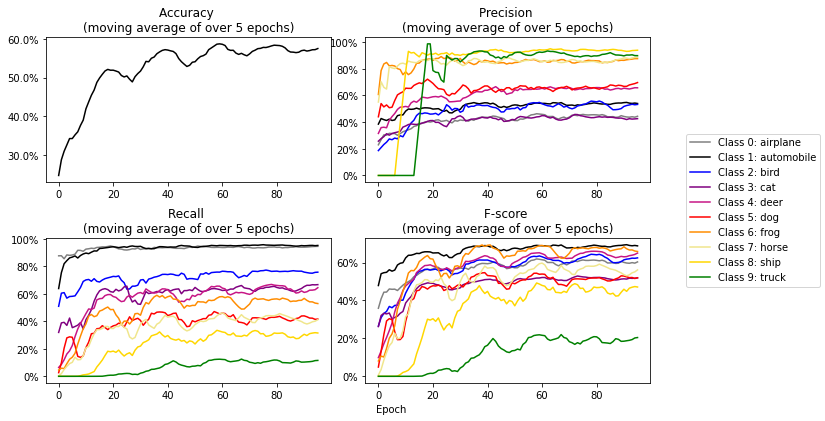

In [22]:
plot_results_multiClass('CIFAR10_LongTail_1000Test.pickle', colors, smooth = 5, vlines=True)

**Results when including the congestion avoidance scheduler with the cosine similarity threshold of 20%**

* Congestion based on F-score
* The threshold is the average all F-score values in that epoch
* Congestion condition parameter is 70%
* A minimum of 10 epochs between successive congestion conditions
* 10% of knowledge is returned on congestion
* For a given class under a congestion condition, only parameters that have acquired knowledge with a minimum cosine similarity (compared to the acquired knowledge for that parameter on all other classes) below 20% return knowledge

In [23]:
train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events = get_cong_avoidance_results_10classes(epochs=100, min_cond=0.7, max_cond = 0.7, mult=0.1, lr=0.1, min_epochs = 10, num_class_avg=10, similarity_threshold=0.2, metric='F-score')

Streaming output truncated to the last 5000 lines.
Learning rate:  0.025075
Epoch counts:  [25, 5, 35, 25, 21, 35, 8, 35, 35, 35]
Condition not met (class 0) ..... 51.39% --> 60.22%
Condition not met (class 1) ..... 51.39% --> 65.76%
Condition not met (class 2) ..... 51.39% --> 58.50%
Condition not met (class 3) ..... 51.39% --> 49.12%
Condition not met (class 4) ..... 51.39% --> 61.08%
Condition not met (class 5) ..... 51.39% --> 45.79%
Condition not met (class 6) ..... 51.39% --> 67.52%
Condition not met (class 7) ..... 51.39% --> 49.49%
Condition not met (class 8) ..... 51.39% --> 47.67%
Condition not met (class 9) ..... 51.39% --> 8.73%
time: 1797.613 sec
Rows: Actual, Columns: Predicted
[[921.  32.  16.  15.   6.   0.   1.   1.   7.   1.]
 [ 19. 967.   2.   6.   1.   1.   2.   1.   0.   1.]
 [137.   8. 669.  98.  55.  12.  15.   4.   2.   0.]
 [ 76.  20.  98. 653.  55.  48.  44.   6.   0.   0.]
 [ 84.   6. 110. 107. 641.   3.  39.   9.   1.   0.]
 [ 56.  19. 119. 370.  61. 332.  2

In [24]:
save_to_file('cond700_fScore_mult010_min10epochs_avg10class_cosine020threshold.pickle', [train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events])

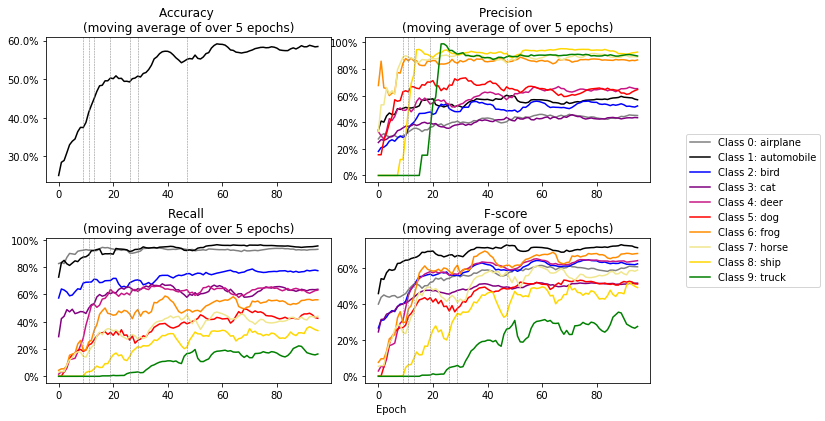

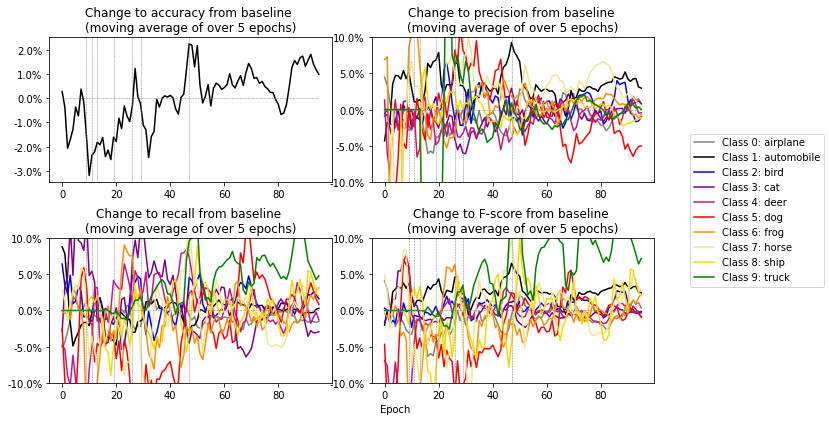

In [25]:
name = 'cond700_fScore_mult010_min10epochs_avg10class_cosine020threshold.pickle'
baseline='CIFAR10_LongTail_1000Test.pickle'
plot_results_multiClass(name, colors, smooth = 5, vlines=True)
plot_results_diff_multiClass(baseline, name, colors, smooth = 5, vlines=True)

**Returning acquired knowledge from all model parameters**

* Congestion based on F-score
* The threshold is the average all F-score values in that epoch
* Congestion condition parameter is 70%
* A minimum of 10 epochs between successive congestion conditions
* 10% of knowledge is returned on congestion
* All parameters return knowledge on congestion

In [26]:
train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events = get_cong_avoidance_results_10classes(epochs=100, min_cond=0.7, max_cond = 0.7, mult=0.1, lr=0.1, min_epochs = 10, num_class_avg=10, similarity_threshold=1)

Streaming output truncated to the last 5000 lines.
Gradient used:  module.layer4.0.conv2.weight , Cosine sim:  0.3319975733757019
Gradient used:  module.layer4.0.bn2.weight , Cosine sim:  0.003990430850535631
Gradient used:  module.layer4.0.bn2.bias , Cosine sim:  0.010382206179201603
Gradient used:  module.layer4.0.downsample.0.weight , Cosine sim:  0.9905808568000793
Gradient used:  module.layer4.0.downsample.1.weight , Cosine sim:  0.03726515546441078
Gradient used:  module.layer4.0.downsample.1.bias , Cosine sim:  0.010382206179201603
Gradient used:  module.layer4.1.conv1.weight , Cosine sim:  0.3302239179611206
Gradient used:  module.layer4.1.bn1.weight , Cosine sim:  0.07929162681102753
Gradient used:  module.layer4.1.bn1.bias , Cosine sim:  0.04960674047470093
Gradient used:  module.layer4.1.conv2.weight , Cosine sim:  0.33125779032707214
Gradient used:  module.layer4.1.bn2.weight , Cosine sim:  0.06350532174110413
Gradient used:  module.layer4.1.bn2.bias , Cosine sim:  0.002219

In [27]:
save_to_file('cond700_fScore_mult010_min10epochs_avg10class_cosine100threshold.pickle', [train_acc, train_P, train_R, train_F, test_acc, test_P, test_R, test_F, cong_events])

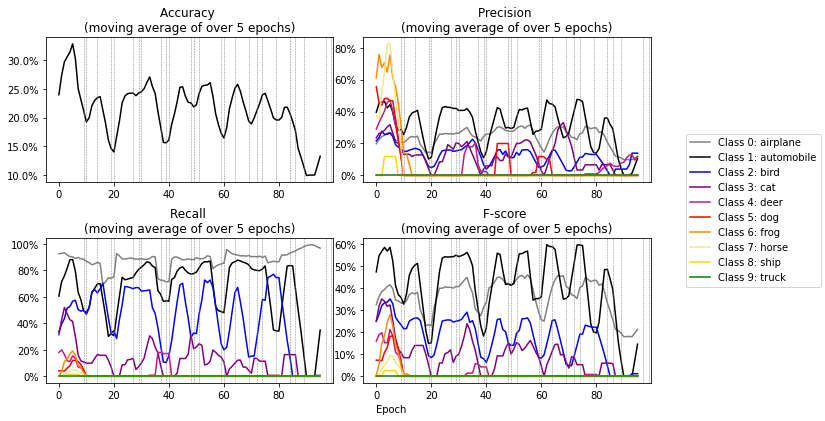

In [29]:
name = 'cond700_fScore_mult010_min10epochs_avg10class_cosine100threshold.pickle'
plot_results_multiClass(name, colors, smooth = 5, vlines=True)